In [29]:
using LinearAlgebra
using Plots,ITensors
using SparseIR
using LaTeXStrings

ITensors.disable_warn_order()
println(ITensors.blas_get_num_threads())
newaxis = [CartesianIndex()]


8


1-element Vector{CartesianIndex{0}}:
 CartesianIndex()

In [30]:
R = 12
N = 2^R
N_p = 100

function random_nonzero(ntrial::Int64)
    for _ in 1:ntrial   #ntrialの回数だけ中の処理を実行
        v = randn()
        if abs(v - 0.0) > 1e-8
            return v    #returnで値を返して処理を停止
        else
            continue    #continueで処理を続行
        end
    end
end

;

$$
G(i\nu) = \sum_{i=1}^{N_p} \frac{c_i}{i\nu - \omega_i} - \frac{1}{i\nu}
$$

$$
g(\nu, \omega) = \frac{1}{i\nu - \omega_i}
$$

In [31]:
#gの定義
g(ν::Float64, ω::Float64) = 1 / (im*ν - ω)

g (generic function with 1 method)

$$
G(\nu, \omega_i, c_i) = \sum_{i=1}^{N_p} \frac{c_i}{i\nu - \omega_i} - \frac{1}{i\nu}
$$

In [32]:
#G(τ)の定義
function Gnu(ν::Float64, ω::Vector, c::Vector)
    result = 0.0
    for i in 1:N_p
        result += c[i] * g(ν, ω[i])
    end
    return (result - (1/(im*ν)))
end

#c_iの作成
cs_0 = zeros(Float64, N_p)
C = 0.0
for i in 1:N_p
    c = abs(random_nonzero(N_p))
    cs_0[i] = c
    C = C + c
end
cs = (1/C) .* cs_0

#ω_iの作成
ωs = zeros(Float64, N_p)
for i in 1:N_p
    ωs[i] = randn()
end

;

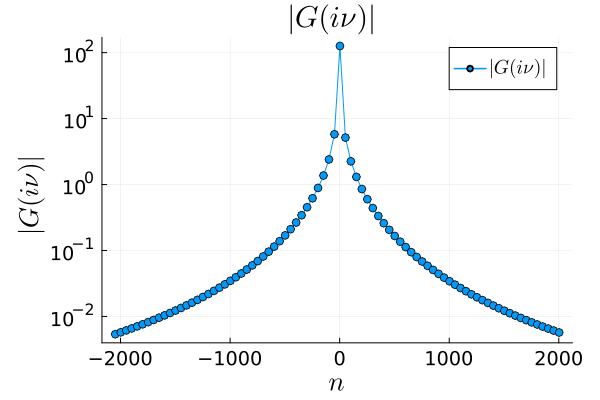

In [33]:
#G(τ)を1D Arrayに変換
β = 1000.0

n = range(-2^(R-1), 2^(R-1), N)
ν = (π/β) .* n
G_nu = [Gnu(v, ωs, cs) for v in ν]
#@show collect(G_tau)
#@assert collect(G_tau) == G_tau

Gnu_abs = abs.(G_nu)

#|G(τ)|のplot
plot_abs = plot(
    yaxis =:log,
    titlefont = font(20), 
    xtickfont = font(13), 
    ytickfont = font(13),
    legendfontsize = 13,
    xguidefont = 18,
    yguidefont = 18,
    markersize = 6,
    title = L"|G(i\nu)|",
    xlabel = L"n",
    ylabel = L"|G(i\nu)|",
    left_margin = 5Plots.mm,
    right_margin = 5Plots.mm
    )
step = 50
plot!(
    plot_abs,
    n[1:step:end],
    Gnu_abs[1:step:end],
    label = L"|G(i\nu)|",
    marker=:o)

In [34]:
G_nu

4096-element Vector{ComplexF64}:
 -0.0023877537349203145 - 0.004825028791754338im
 -0.0023901643638002492 - 0.0048316605067578455im
  -0.002392578535357166 - 0.0048383042630343875im
 -0.0023949962562671494 - 0.004844960087723477im
 -0.0023974175332213384 - 0.004851628008037373im
 -0.0023998423729259754 - 0.004858308051261834im
 -0.0024022707821024307 - 0.00486500024475614im
 -0.0024047027674872525 - 0.0048717046159529875im
 -0.0024071383358322046 - 0.004878421192359372im
  -0.002409577493904297 - 0.004885150001556149im
                        ⋮
 -0.0024071383358322046 + 0.004878421192359372im
  -0.002404702767487254 + 0.00487170461595296im
 -0.0024022707821024307 + 0.00486500024475614im
  -0.002399842372925974 + 0.004858308051261806im
 -0.0023974175332213384 + 0.004851628008037373im
   -0.00239499625626715 + 0.004844960087723504im
  -0.002392578535357166 + 0.0048383042630343875im
 -0.0023901643638002497 + 0.004831660506757873im
 -0.0023877537349203145 + 0.004825028791754338im

In [35]:
#ボンド次元をプロットする場所を準備

gr(size=(600, 400))

plot_bonddim = plot(
    yaxis = :log10, 
    titlefontsize = 20,
    legendfontsize = 13,
    tickfontsize = 13,
    guidefont = 18,
    markersize = 6,
    legend = :topright,
    xticks = 1:1:R-1,
    yticks =([10^(0), 10^(1), 10^(2)]),
    ylims = (10^(0), 10^2),
    title = L"\mathrm{Bond~Dimension, \ cutoff = }10^{-20}",
    xlabel = L"\mathrm{Bond~b}",
    ylabel = L"\mathrm{Bond~Dimension}"
)


#β=1000.0

#厳密なMPSの作成
sitesx = [Index(2, "Qubit,x=$n") for n in 1:R]
tensor = ITensor(G_nu, reverse(sitesx))
M = MPS(tensor, sitesx)

#圧縮前のボンド次元をプロット
plot!(plot_bonddim, 
    linkdims(M),
    linestyle = :dash,
    label = "No compression")


#圧縮前のMPSをベクトルに変形
tensor_reconst = reduce(*, M)   
tmp = Array(tensor_reconst,  reverse(sitesx))
gtau_reconst = vec(tmp)

#cutoff=1e-20 で圧縮したMPSをベクトルに変形
M_compression = MPS(tensor, sitesx, cutoff = 1e-20)
tensor_compression_reconst = reduce(*, M_compression)
tmp_compression = Array(tensor_compression_reconst, reverse(sitesx))
gnu_compression_reconst = vec(tmp_compression)
;

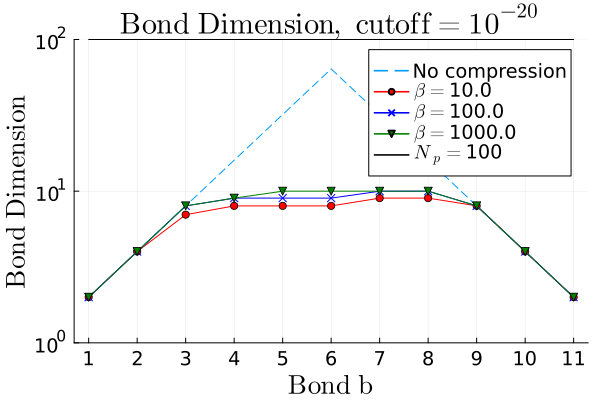

In [36]:
beta = [10.0, 100.0, 1000.0]
plot_color = ["red", "blue", "green"]
markershape = [:circle, :xcross, :dtriangle]

G_nu_all = Array{Array{ComplexF64}}(undef, length(beta))

#各betaの値をプロット
for i in 1:length(beta)
    ν = (π/beta[i]) .* n
    G_nu_beta = [Gnu(v, ωs, cs) for v in ν]
    sitesx = [Index(2, "Qubit,x=$n") for n in 1:R]
    tensor_comp = ITensor(G_nu_beta, reverse(sitesx))
    M_comp = MPS(tensor_comp, sitesx; cutoff = 1e-20)

    G_nu_all[i] = G_nu_beta
    
    plot!(
        plot_bonddim, 
        linkdims(M_comp),
        markershape = markershape[i],
        label = L"\beta="*string(beta[i]),
        color = plot_color[i]
    )
end

#N_pのプロット
x = 1.0:0.01:11.0
y = fill(100.0, length(x))
plot!(
    plot_bonddim,
    x, 
    y,
    label = L"N_p="*string(N_p),
    color = "black"
)

display(plot_bonddim)

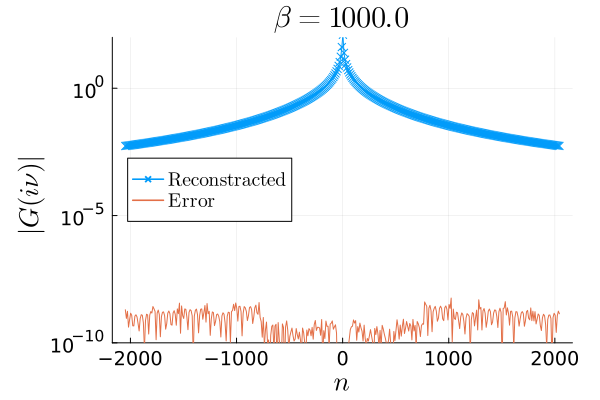

In [37]:
#誤差を格納した配列の作成
error = abs.(G_nu .- gnu_compression_reconst)

#誤差と再構築したG(τ)をプロットする場所を作成
plot_error = plot(
    yaxis =:log,
    yticks =([10^(0), 10^(-5), 10^(-10)]),
    ylims = (10^(-10), 10^2),
    titlefont = font(20), 
    xtickfont = font(13), 
    ytickfont = font(13),
    legendfontsize = 13,
    xguidefont = 18,
    yguidefont = 18,
    markersize = 6,
    title = L"\mathrm{\beta = 1000.0}",
    xlabel = L"n",
    ylabel = L"|G(i\nu)|",
    left_margin = 5Plots.mm,
    right_margin = 5Plots.mm, legend = :left
    )

#再構築したG(τ)のプロット
plot!(
    plot_error,
    n[1:10:end],
    abs.(gnu_compression_reconst[1:10:end]),
    label = L"\mathrm{Reconstracted}",
    markershape = :xcross
    )

#誤差のプロット
plot!(
    plot_error,
    n[1:10:end], 
    error[1:10:end], 
    label = L"\mathrm{Error}"
    )

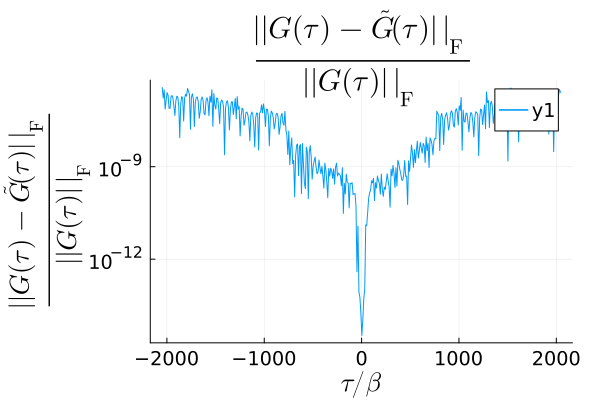

In [38]:
error_numerator = []
for i in 1:N
    error1 = 0.0
    error1 = sqrt(abs(G_nu[i] - gnu_compression_reconst[i]) ^2)

    push!(error_numerator, error1)
end

error_denominator = []
for j in 1:N
    error2 = 0.0
    error2 = sqrt(abs(G_nu[j]) ^2)

    push!(error_denominator, error2)
end

tmp_error = []
for k in 1:N
    error = 0.0
    error = (error_numerator[k])/(error_denominator[k])
    push!(tmp_error, error)
end

plot_tmp_error = plot(
    yaxis =:log,
    #yticks =([10^(-1), 10^(-6), 10^(-11)]),
    #ylims = (10^(-13), 10^0),
    titlefont = font(20), 
    xtickfont = font(13), 
    ytickfont = font(13),
    legendfontsize = 13,
    xguidefont = 18,
    yguidefont = 18,
    markersize = 6,
    title = L"\frac{||G(\tau) - \tilde{G}(\tau)|| _{\mathrm{F}}}{||G(\tau)||_{\mathrm{F}}}",
    xlabel = L"\tau / \beta",
    ylabel = L"\frac{||G(\tau) - \tilde{G}(\tau)|| _{\mathrm{F}}}{||G(\tau)||_{\mathrm{F}}}",
    left_margin = 5Plots.mm,
    right_margin = 5Plots.mm
    )

plot!(
    plot_tmp_error, 
    n[1:10:end], 
    tmp_error[1:10:end],
    )

In [39]:
#MPSを構成する各行列と特異値を作成する関数
function mps_12(g::Vector{ComplexF64}, r::Int)

    #特異値分解した右特異ベクトルをreshapeして格納
    M = Array{Array{ComplexF64}}(undef, r)
    #それぞれの特異値を格納
    S = Array{Vector{Float64}}(undef, r)
    #特異値分解した左特異ベクトルを格納
    V = Array{Array{ComplexF64}}(undef, r)

    #特異値分解するときの分離するテンソルの左側の脚の次元
    p_left = Array{Int}(undef, r)
    for i in 0:r-1
        if i < (r+1)/2
            p_left[i+1] = i
        else
            p_left[i+1] = r-i
        end
    end

    #特異値分解するときの分離するテンソルの右側の脚の次元
    p_right = reverse(p_left)

    #特異値分解するときの分解するテンソルの左側の脚の次元
    p_big_left = Array{Int}(undef, r-1)
    for i in 1:r-1
        if i <= r/2+1
            p_big_left[i] = i
        else
            p_big_left[i] = r-i+2
        end
    end

    #特異値分解
    for i in 1:1:r
        if i == 1
            u, s, v = svd(Array(reshape(g, 2^1, 2^(12-1))))
            M[i] = u
            S[i] = s
            V[i] = v
        elseif i == r
            m = diagm(S[r-1]) * V[i-1]
            M[i] = m
        else
            u, s, v = svd(Array(reshape(diagm(S[i-1]) * V[i-1]', 2^p_big_left[i], 2^(12-i))))
            m = reshape(u, 2^p_left[i], 2, 2^p_right[i])
            M[i] = m
            S[i] = s
            V[i] = v
        end
    end

    return M, S
end

;

In [40]:
#MPSを組み立てる関数
#=
function mps_12_con(M::Array)
    return mps = ein"ab,bcd,def,fgh,hij,jkl,lmn,nop,pqr,rst,tuv,vw -> acegik"(M[1],M[2],M[3],M[4],M[5],M[6],M[7],M[8],M[9],M[10],M[11],M[12])
end
=#

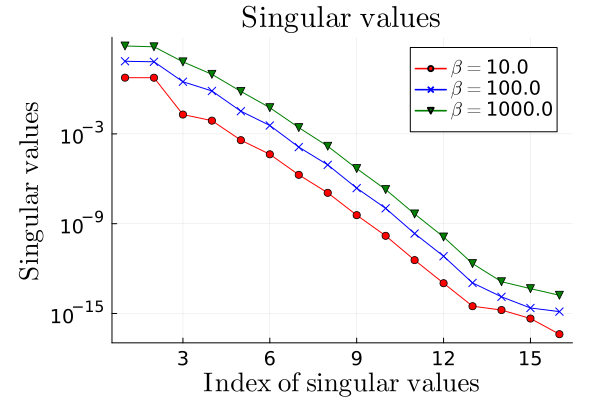

In [41]:
#beta = [10.0, 100.0, 1000.0]
#plot_color = ["red", "blue", "green"]
#markershape = [:circle, :xcross, :dtriangle]

#特異値をプロットする場所の作成
plot_singular_value_beta = plot(
  yaxis =:log,
  yticks =([10^(-3), 10^(-9), 10^(-15)]),
  #ylims = (10^(-15), 10^3),
  #xlims = (0.0, 40.0),
  title = L"\mathrm{Singular~values}",
  xlabel = L"\mathrm{Index~of~singular~values}",
  ylabel = L"\mathrm{Singular~values}",
  left_margin = 5Plots.mm,
  right_margin = 5Plots.mm,
  titlefontsize = 20,
  legendfontsize = 13,
  tickfontsize = 13,
  guidefont = 18,
  markersize = 6,
  )

#５番目の脚の特異値をプロット
for b in 1:length(beta)
  
    mps_beta, singular_value_beta = mps_12(G_nu_all[b], R)
    
    plot!(
      plot_singular_value_beta, 
      singular_value_beta[4], #５番目の特異値
      label = L"\beta = "*string(beta[b]), 
      markershape = markershape[b],
      color = plot_color[b]
      )

end

plot_singular_value_beta